In [194]:
import pandas as pd
import numpy as np
from scipy import stats
choice_data =np.load('choice_data_binned.npy')
num_subjects=len(choice_data)
print(num_subjects)
worry_data=np.load('PSWQ_cleaned_ordered.npy')
BDI_data=np.load('BDI_cleaned_ordered.npy')
OCD_data=np.load('OCD_cleaned_ordered.npy')
MASQ_data=np.load('MASQ_cleaned_ordered.npy')


174


# Proportions Z statistic via permutation test

In [213]:
from statsmodels.stats.proportion import proportions_ztest as pz
from random import shuffle as shuf

sample_size=174
ct=choice_data[:,2]
cp=choice_data[:,1]
ones=np.array([len([h for h in ct if h==1]),len([h for h in cp if h==1])])
obs=np.array([sample_size,sample_size])
t_orig,pval=pz(ones,obs)
print('original t value: {}'.format(t_orig))
ts=[]
for i in range(10000):
    x=ct.tolist()+cp.tolist()
    shuf(x)
    shuf(x)
    g1=x[0:sample_size]
    o1=len([h for h in g1 if h==1])
    g2=x[sample_size:len(x)]
    o2=len([h for h in g2 if h==1])
    ones=np.array([o1,o2])
    
    t_temp,pval=pz(ones,obs)
    ts.append(t_temp)

ts.sort()

index_t=[i for i, j in enumerate(ts) if j == t_orig]
max_i=max(index_t)
print(max_i)
p_val=1-(max_i/10000)
print('pvalue after permutation: {}'.format(p_val))





original t value: 1.7909140883608574
97128
pvalue after permutation: 0.028719999999999968


In [104]:
from statsmodels.stats.multitest import multipletests as mt

alpha=.05

pvals=[0.16,0.10,0.07,0.02,0.03]

print(mt(pvals,alpha, method='fdr_bh', is_sorted=False, returnsorted=False))


(array([False, False, False, False, False]), array([0.16      , 0.125     , 0.11666667, 0.075     , 0.075     ]), 0.010206218313011495, 0.01)


# Model: Random subject effect, fixed condition effect

In [118]:
from pystan import StanModel


model_input='''
data {

    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int Choice[NxSubjects, NxConditions];
}

parameters {   
  // Grand mean
  vector[NxSubjects] a0;
  real<lower=0,upper=3> sigma_subject;
  
  //Conditions
  vector[NxConditions] aW;  
}

transformed parameters {

vector<lower=0,upper=1>[NxSubjects] theta_neutral;
vector<lower=0,upper=1>[NxSubjects] theta_cp;
vector<lower=0,upper=1>[NxSubjects] theta_ct;
vector<lower=0,upper=1>[NxSubjects] theta_rp;
vector<lower=0,upper=1>[NxSubjects] theta_rt;


// Translate to sum-to-zero deflections away from Grand Mean 
real b0;
vector[NxConditions] bConditions;

    

// Mean predicted values (before logistic transform) per conditionXsubject cell

matrix[NxConditions,NxSubjects] m;

  // Convert parameters to sum-to-zero
  
  for ( u in 1:NxConditions){
          for (k in 1:NxSubjects){
              m[u,k] = a0[k]+aW[u];
     } 
  }
  // Grand mean (mean over matrix of all cells)
  b0 = mean(m);
  
  //Effects of Condition (how average effect across subjects is different from Grand Mean)
  for (j in 1:NxConditions){bConditions[j]=mean(m[j,1:NxSubjects])-b0;}
  


for (k in 1:NxSubjects){
        theta_neutral[k] = inv_logit(a0[k]+aW[1]);
        theta_cp[k] = inv_logit(a0[k]+aW[2]);
        theta_ct[k] = inv_logit(a0[k]+aW[3]);
        theta_rp[k] = inv_logit(a0[k]+aW[4]);
        theta_rt[k] = inv_logit(a0[k]+aW[5]);
    }
}
model {    
    sigma_subject ~ uniform(0,5);
    a0 ~ normal(0,sigma_subject);
    aW ~ normal(0,5);
    
    for (k in 1:NxSubjects){
        // Neutral condition choices
        Choice[k,1] ~ bernoulli(theta_neutral[k]);

        // Positive-common choices
        Choice[k,2] ~ bernoulli(theta_cp[k]);

        // Threat-common choices
        Choice[k,3] ~ bernoulli(theta_ct[k]); 

        // Positive-rare choices
        Choice[k,4] ~ bernoulli(theta_rp[k]);

        // Threat-rare choices
        Choice[k,5] ~ bernoulli(theta_rt[k]);
     
          }    
      
    }
    
'''
data_input = {
              'Choice':choice_data,#choice data
              'NxConditions':5,
              'NxSubjects':num_subjects
                    }

controls={'adapt_delta':0.9,
         'max_treedepth':18}

model_fit = StanModel(model_code=model_input)
fit_fe = model_fit.sampling(data=data_input,iter=4000,control=controls)
print(fit_fe)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c4cb7f676c64e4cfaf68b78d9f653f7a NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_c4cb7f676c64e4cfaf68b78d9f653f7a.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

                      mean se_mean     sd    2.5%     25%     50%    75%  97.5%  n_eff   Rhat
a0[1]                -1.28  8.3e-3   0.77   -2.85    -1.8   -1.27  -0.76   0.17   8781    1.0
a0[2]                 1.11  8.4e-3   0.87   -0.51     0.5    1.07   1.65   2.96  10829    1.0
a0[3]                 0.42  7.2e-3    0.8   -1.07   -0.12    0.39   0.93   2.07  12545    1.0
a0[4]                -1.29  8.1e-3   0.76   -2.84   -1.78   -1.26  -0.77   0.15   8822    1.0
a0[5]                 0.42  7.5e-3   0.82    -1.1   -0.16    0.39   0.95   2.06  12060    1.0
a0[6]                -0.71  7.4e-3   0.75    -2.2   -1.21    -0.7  -0.22   0.77  10349    1.0
a0[7]                 0.42  7.5e-3    0.8   -1.09   -0.12    0.39   0.93   2.07  11401    1.0
a0[8]                -0.72  7.4e-3   0.76    -2.2   -1.23  

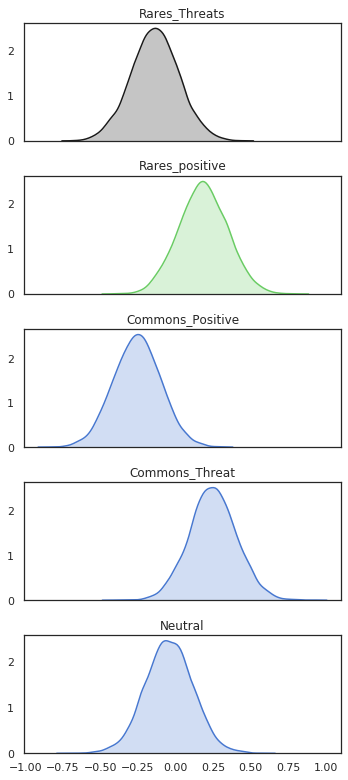

In [228]:
import matplotlib.pyplot as plt
import seaborn as sns
from bayesian_bootstrap.bootstrap import mean, highest_density_interval
import pandas as pd

fit_df_2 = fit_fe.to_dataframe()

# best_subs=[]
# for i in range(1,176):
#     if np.mean(fit_df_2['a0[{}]'.format(i)])>0.99:
#         best_subs.append(i-1)
        
# print(best_subs)
# print('\n')

#Extract data
chain_idx = fit_df_2['draw']
neutral = fit_df_2['bConditions[{}]'.format(1)]
common_p = fit_df_2['bConditions[{}]'.format(2)]
common_t = fit_df_2['bConditions[{}]'.format(3)]
rare_p = fit_df_2['bConditions[{}]'.format(4)]
rare_t = fit_df_2['bConditions[{}]'.format(5)]

diff_v = rare_p-rare_t
rares=((rare_p+rare_t)/2.0)
commons=((common_p+common_t)/2.0)
diff_type=(common_t-rare_t)-(common_p-rare_p)
diff_rare=rare_p-rare_t
diff_ct_rares=common_t-rares
diff_common=common_t-common_p
diff_raret=common_t-rare_t
diff_n=neutral-rare_t
d_cp=rare_p-common_p
diff_n_ct=common_t-neutral
diff_n_cp=neutral-common_p


#Compute HDIs
l_ct, r_ct = highest_density_interval(common_t,alpha=0.10)
l_cp, r_cp = highest_density_interval(common_p,alpha=0.10)
l_r, r_r = highest_density_interval(diff_rare,alpha=0.10)   
l_rt,r_rt=highest_density_interval(diff_raret,alpha=0.10)
l_n,r_n=highest_density_interval(neutral,alpha=0.10)
le,re=highest_density_interval(diff_ct_rares,alpha=0.10)
l,r=highest_density_interval(d_cp,alpha=0.10)
nm,mm=highest_density_interval(diff_common,alpha=0.10)
lc,hc=highest_density_interval(diff_type,alpha=0.10)
lx,rx=highest_density_interval(diff_n_ct,alpha=0.30)
lxy,rxy=highest_density_interval(diff_n_cp,alpha=0.10)


rope=0.009


sns.set(style="white",
        palette="muted",
        color_codes=True)

f, axs = plt.subplots(5, 1, figsize=(5, 11),sharex=True)

ax0=sns.distplot(rare_t, hist=False,kde_kws={"shade": True},color="k", ax=axs[0])
ax0.set(title='Rares_Threats',xlabel='')

ax1=sns.distplot(rare_p, hist=False,kde_kws={"shade": True},color="g", ax=axs[1])
ax1.set(title='Rares_positive',xlabel='')


ax2=sns.distplot(common_p, hist=False, kde_kws={"shade": True},color="b", ax=axs[2])
ax2.set(title='Commons_Positive',xlabel='')

axct=sns.distplot(common_t, hist=False, kde_kws={"shade": True},color="b", ax=axs[3])
axct.set(title='Commons_Threat',xlabel='')

axct=sns.distplot(neutral, hist=False, kde_kws={"shade": True},color="b", ax=axs[4])
axct.set(title='Neutral',xlabel='')



plt.tight_layout()
plt.show()


0.07979145661221687
0.010526112064805027


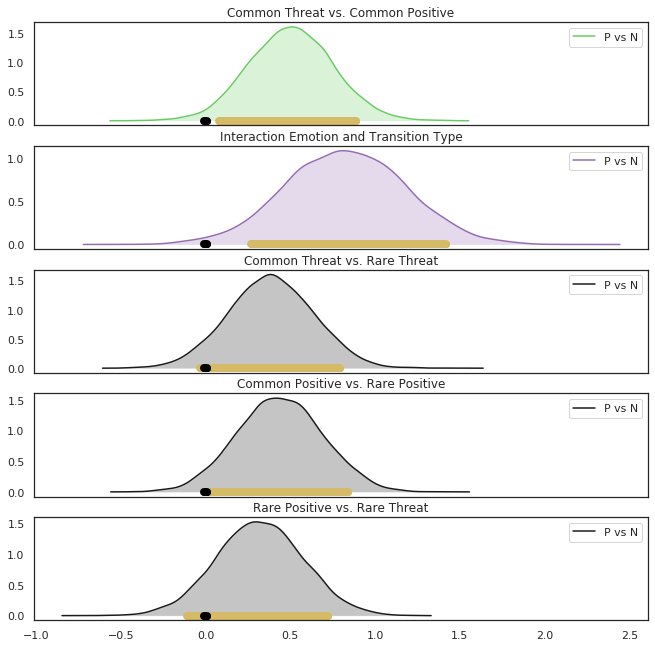

In [223]:
f, axs = plt.subplots(5, 1, figsize=(11, 11),sharex=True)

axv=sns.distplot(diff_type, hist=False, kde_kws={"shade": True},color="m", ax=axs[1],label='P vs N')
axv.set(title='Interaction Emotion and Transition Type',xlabel='')

axs[1].plot([lc, hc],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[1].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

axv=sns.distplot(diff_common, hist=False, kde_kws={"shade": True},color="g", ax=axs[0],label='P vs N')
axv.set(title='Common Threat vs. Common Positive',xlabel='')

axs[0].plot([nm, mm],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[0].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

axv=sns.distplot(diff_raret, hist=False, kde_kws={"shade": True},color="k", ax=axs[2],label='P vs N')
axv.set(title='Common Threat vs. Rare Threat',xlabel='')

axs[2].plot([l_rt, r_rt],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[2].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


axv=sns.distplot(d_cp, hist=False, kde_kws={"shade": True},color="k", ax=axs[3],label='P vs N')
axv.set(title='Common Positive vs. Rare Positive',xlabel='')

axs[3].plot([l, r],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[3].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

axv=sns.distplot(diff_rare, hist=False, kde_kws={"shade": True},color="k", ax=axs[4],label='P vs N')
axv.set(title='Rare Positive vs. Rare Threat',xlabel='')

axs[4].plot([l_r, r_r],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[4].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

print(nm)
print(l)

# Neutral condition relative to emotion conditions

0.03636136845134397


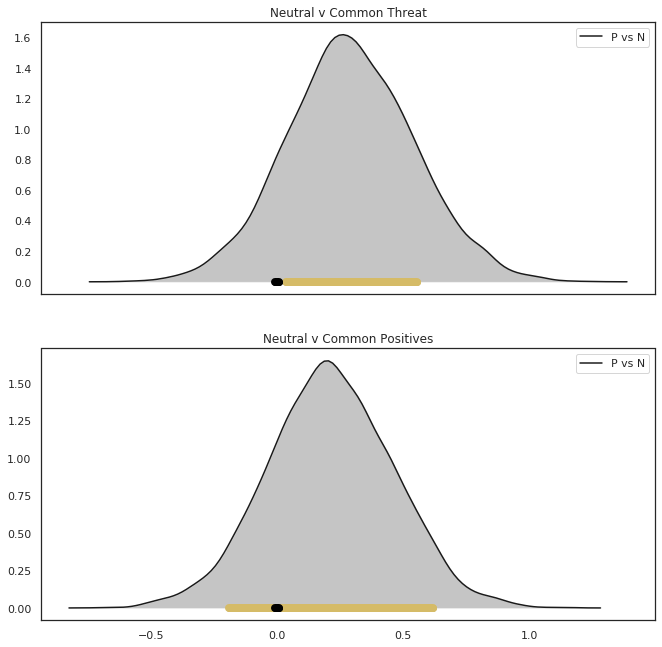

In [229]:
f, axs = plt.subplots(2, 1, figsize=(11, 11),sharex=True)

axv=sns.distplot(diff_n_ct, hist=False, kde_kws={"shade": True},color="k", ax=axs[0],label='P vs N')
axv.set(title='Neutral v Common Threat',xlabel='')

axs[0].plot([lx, rx],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[0].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

print(lx)

axv=sns.distplot(diff_n_cp, hist=False, kde_kws={"shade": True},color="k", ax=axs[1],label='P vs N')
axv.set(title='Neutral v Common Positives',xlabel='')

axs[1].plot([lxy, rxy],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[1].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

# Self Report OCD symptoms is related to worse performance

In [217]:
from scipy.stats import spearmanr as corrS

bls=[]
for sub in range(1,175):
    bls.append(np.mean(fit_df_2['a0[{}]'.format(sub)]))

print(corrS(OCD_data,bls))

SpearmanrResult(correlation=-0.17217290034233848, pvalue=0.02310230686132289)


# 5 dimensional multivariate distribution

## look up prior on covariance

# Model on diff genders

In [179]:
import pandas as pd
import numpy as np
from scipy import stats
choice_data_f=np.load('choice_data_binned_female.npy')
num_subjects_f=len(choice_data_f)
print(choice_data_f.shape)
worry_dataf=np.load('PSWQ_cleaned_ordered_female.npy')
BDI_dataf=np.load('BDI_cleaned_ordered_female.npy')
OCD_dataf=np.load('OCD_cleaned_ordered_female.npy')
MASQ_dataf=np.load('MASQ_cleaned_ordered_female.npy')
print(len(worry_dataf))

(86, 5)
86


In [190]:
from pystan import StanModel


model_input='''
data {

    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int Choice[NxSubjects, NxConditions];
}

parameters {   
  // Grand mean
  vector[NxSubjects] a0;
  real<lower=0,upper=5> sigma_subject;
  
  //Conditions
  vector[NxConditions] aW;  
}

transformed parameters {

vector<lower=0,upper=1>[NxSubjects] theta_neutral;
vector<lower=0,upper=1>[NxSubjects] theta_cp;
vector<lower=0,upper=1>[NxSubjects] theta_ct;
vector<lower=0,upper=1>[NxSubjects] theta_rp;
vector<lower=0,upper=1>[NxSubjects] theta_rt;


// Translate to sum-to-zero deflections away from Grand Mean 
real b0;
vector[NxConditions] bConditions;

    

// Mean predicted values (before logistic transform) per conditionXsubject cell

matrix[NxConditions,NxSubjects] m;

  // Convert parameters to sum-to-zero
  
  
    for (k in 1:NxSubjects){
        for (u in 1:NxConditions){
        m[u,k] = a0[k]+aW[u];
        
     } 
  }
  
  // Grand mean (mean over matrix of all cells)
  b0 = mean(m);
  
  //Effects of Condition (how average effect across subjects is different from Grand Mean)
  for (j in 1:NxConditions){bConditions[j]=mean(m[j,1:NxSubjects])-b0;}
  


for (k in 1:NxSubjects){
        theta_neutral[k] = inv_logit(a0[k]+aW[1]);
        theta_cp[k] = inv_logit(a0[k]+aW[2]);
        theta_ct[k] = inv_logit(a0[k]+aW[3]);
        theta_rp[k] = inv_logit(a0[k]+aW[4]);
        theta_rt[k] = inv_logit(a0[k]+aW[5]);
    }
}
model {    
    sigma_subject ~ uniform(0,5);
    a0 ~ normal(0,sigma_subject);
    aW ~ normal(0,5);
    
    for (k in 1:NxSubjects){
        // Neutral condition choices
        Choice[k,1] ~ bernoulli(theta_neutral[k]);

        // Positive-common choices
        Choice[k,2] ~ bernoulli(theta_cp[k]);

        // Threat-common choices
        Choice[k,3] ~ bernoulli(theta_ct[k]); 

        // Positive-rare choices
        Choice[k,4] ~ bernoulli(theta_rp[k]);

        // Threat-rare choices
        Choice[k,5] ~ bernoulli(theta_rt[k]);
     
          }    
      
    }
    
'''
data_input = {
              'Choice':choice_data_f,#choice data
              'NxConditions':5,
              'NxSubjects':num_subjects_f
                    }

controls={'adapt_delta':0.9,
         'max_treedepth':18}

model_fitf = StanModel(model_code=model_input)
fit_fe_female = model_fitf.sampling(data=data_input,iter=4000,control=controls)
print(fit_fe_female)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f39905f4744eecb3574cfd012e05bb2e NOW.


Inference for Stan model: anon_model_f39905f4744eecb3574cfd012e05bb2e.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

                    mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
a0[1]              -1.98    0.01   0.96   -3.99   -2.57  -1.92  -1.33  -0.24   8190    1.0
a0[2]               0.47  9.2e-3   1.03   -1.43   -0.23   0.41   1.11   2.65  12455    1.0
a0[3]               1.72    0.01   1.31   -0.52    0.79   1.59   2.51   4.66   9098    1.0
a0[4]              -1.96    0.01   0.99   -4.07   -2.58  -1.92  -1.29  -0.16   8007    1.0
a0[5]               1.74    0.01   1.33   -0.51     0.8   1.61   2.54   4.65  10469    1.0
a0[6]              -1.19  9.1e-3   0.87   -2.97   -1.75  -1.18   -0.6   0.48   9266    1.0
a0[7]               1.73    0.01   1.32   -0.51     0.8    1.6   2.53    4.7   9735    1.0
a0[8]               0.47  9.5e-3   1.03   -1.41   -0.24   0.42   1.12   2.66  11855

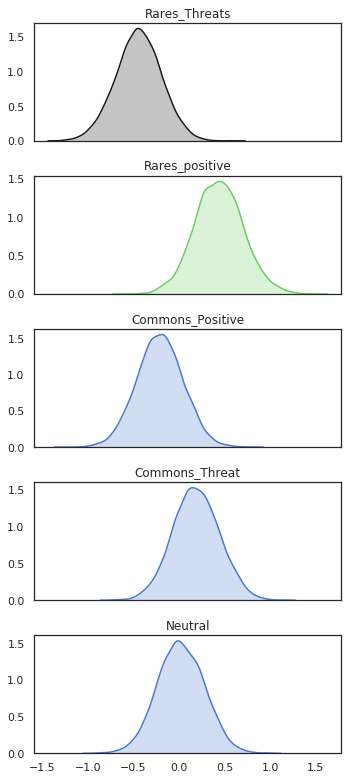

-0.07494241614081765


In [198]:
import matplotlib.pyplot as plt
import seaborn as sns
from bayesian_bootstrap.bootstrap import mean, highest_density_interval
import pandas as pd

fit_df_2 = fit_fe_female.to_dataframe()

# best_subs=[]
# for i in range(1,176):
#     if np.mean(fit_df_2['a0[{}]'.format(i)])>0.99:
#         best_subs.append(i-1)
        
# print(best_subs)
# print('\n')

#Extract data
chain_idx = fit_df_2['draw']
neutral = fit_df_2['bConditions[{}]'.format(1)]
common_p = fit_df_2['bConditions[{}]'.format(2)]
common_t = fit_df_2['bConditions[{}]'.format(3)]
rare_p = fit_df_2['bConditions[{}]'.format(4)]
rare_t = fit_df_2['bConditions[{}]'.format(5)]

diff_v = rare_p-rare_t
rares=((rare_p+rare_t)/2.0)
commons=((common_p+common_t)/2.0)
diff_type=(common_t-rare_t)-(common_p-rare_p)
diff_rare=rare_p-rare_t
diff_ct_rares=common_t-rares
diff_common=common_t-common_p
diff_raret=common_t-rare_t
diff_n=neutral-rare_t
d_cp=rare_p-common_p
diff_n_ct=rare_p-neutral
diff_n_cp=neutral-common_p


#Compute HDIs
l_ct, r_ct = highest_density_interval(common_t)
l_cp, r_cp = highest_density_interval(common_p)
l_rt, r_rt = highest_density_interval(rare_t)
l_rp, r_rp = highest_density_interval(rare_p)

l_r, r_r = highest_density_interval(diff_rare)   
l_n,r_n=highest_density_interval(neutral)
le,re=highest_density_interval(diff_ct_rares)
l,r=highest_density_interval(d_cp)
nm,mm=highest_density_interval(diff_common)
lc,hc=highest_density_interval(diff_type)
lx,rx=highest_density_interval(diff_n_ct)
lxy,rxy=highest_density_interval(diff_n_cp)
rcr,lcr=highest_density_interval(diff_raret)


rope=0.009


sns.set(style="white",
        palette="muted",
        color_codes=True)

f, axs = plt.subplots(5, 1, figsize=(5, 11),sharex=True)

ax0=sns.distplot(rare_t, hist=False,kde_kws={"shade": True},color="k", ax=axs[0])
ax0.set(title='Rares_Threats',xlabel='')

# axs[0].plot([l_rt, r_rt],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[0].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(rare_p, hist=False,kde_kws={"shade": True},color="g", ax=axs[1])
ax1.set(title='Rares_positive',xlabel='')

# axs[1].plot([l_rp, r_rp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[1].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


ax2=sns.distplot(common_p, hist=False, kde_kws={"shade": True},color="b", ax=axs[2])
ax2.set(title='Commons_Positive',xlabel='')

# axs[2].plot([l_cp, r_cp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[2].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

axct=sns.distplot(common_t, hist=False, kde_kws={"shade": True},color="b", ax=axs[3])
axct.set(title='Commons_Threat',xlabel='')

# axs[3].plot([l_ct, r_ct],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[3].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

axct=sns.distplot(neutral, hist=False, kde_kws={"shade": True},color="b", ax=axs[4])
axct.set(title='Neutral',xlabel='')



plt.tight_layout()
plt.show()
print(l_rp)

-0.3984171373567009
0.0957910716772189


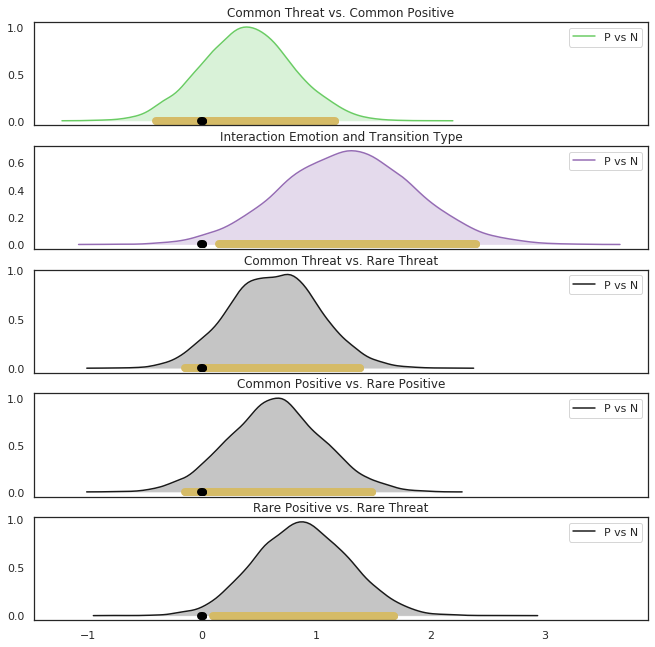

In [199]:
f, axs = plt.subplots(5, 1, figsize=(11, 11),sharex=True)

axv=sns.distplot(diff_type, hist=False, kde_kws={"shade": True},color="m", ax=axs[1],label='P vs N')
axv.set(title='Interaction Emotion and Transition Type',xlabel='')

axs[1].plot([lc, hc],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[1].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

axv=sns.distplot(diff_common, hist=False, kde_kws={"shade": True},color="g", ax=axs[0],label='P vs N')
axv.set(title='Common Threat vs. Common Positive',xlabel='')

axs[0].plot([nm, mm],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[0].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

axv=sns.distplot(diff_raret, hist=False, kde_kws={"shade": True},color="k", ax=axs[2],label='P vs N')
axv.set(title='Common Threat vs. Rare Threat',xlabel='')

axs[2].plot([rcr, lcr],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[2].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


axv=sns.distplot(d_cp, hist=False, kde_kws={"shade": True},color="k", ax=axs[3],label='P vs N')
axv.set(title='Common Positive vs. Rare Positive',xlabel='')

axs[3].plot([l, r],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[3].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

axv=sns.distplot(diff_rare, hist=False, kde_kws={"shade": True},color="k", ax=axs[4],label='P vs N')
axv.set(title='Rare Positive vs. Rare Threat',xlabel='')

axs[4].plot([l_r, r_r],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[4].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

print(nm)
print(l_r)

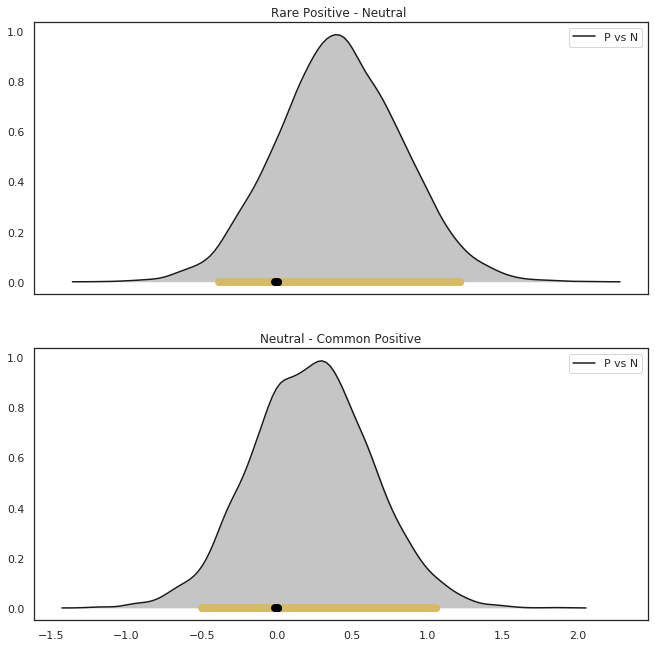

In [200]:
f, axs = plt.subplots(2, 1, figsize=(11, 11),sharex=True)

axv=sns.distplot(diff_n_ct, hist=False, kde_kws={"shade": True},color="k", ax=axs[0],label='P vs N')
axv.set(title='Rare Positive - Neutral ',xlabel='')

axs[0].plot([lx, rx],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[0].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

axv=sns.distplot(diff_n_cp, hist=False, kde_kws={"shade": True},color="k", ax=axs[1],label='P vs N')
axv.set(title='Neutral - Common Positive',xlabel='')

axs[1].plot([lxy, rxy],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[1].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

In [161]:
from scipy.stats import spearmanr as corrS

bls=[]
for sub in range(1,87):
    bls.append(np.mean(fit_df_2['theta_neutral[{}]'.format(sub)]))

print(corrS(MASQ_dataf,bls))

SpearmanrResult(correlation=-0.12703564511419757, pvalue=0.24378813231908447)


# Males

In [162]:
import pandas as pd
import numpy as np
from scipy import stats
choice_data_m=np.load('choice_data_binned_male.npy')
num_subjects_m=len(choice_data_m)
worry_dataM=np.load('PSWQ_cleaned_ordered_male.npy')
BDI_dataM=np.load('BDI_cleaned_ordered_male.npy')
OCD_dataM=np.load('OCD_cleaned_ordered_male.npy')
MASQ_dataM=np.load('MASQ_cleaned_ordered_male.npy')


In [201]:
from pystan import StanModel


model_input2='''
data {

    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int Choice[NxSubjects, NxConditions];
}

parameters {   
  // Grand mean
  vector[NxSubjects] a0;
  
  //Conditions
  vector[NxConditions] aW;  
}

transformed parameters {

vector<lower=0,upper=1>[NxSubjects] theta_neutral;
vector<lower=0,upper=1>[NxSubjects] theta_cp;
vector<lower=0,upper=1>[NxSubjects] theta_ct;
vector<lower=0,upper=1>[NxSubjects] theta_rp;
vector<lower=0,upper=1>[NxSubjects] theta_rt;


// Translate to sum-to-zero deflections away from Grand Mean 
real b0;
vector[NxConditions] bConditions;

    

// Mean predicted values (before logistic transform) per conditionXsubject cell

matrix[NxConditions,NxSubjects] m;

  // Convert parameters to sum-to-zero
  
  for ( u in 1:NxConditions){
          for (k in 1:NxSubjects){
              m[u,k] = a0[k]+aW[u];
     } 
  }
  // Grand mean (mean over matrix of all cells)
  b0 = mean(m);
  
  //Effects of Condition (how average effect across subjects is different from Grand Mean)
  for (j in 1:NxConditions){bConditions[j]=mean(m[j,1:NxSubjects])-b0;}
  


for (k in 1:NxSubjects){
        theta_neutral[k] = inv_logit(a0[k]+aW[1]);
        theta_cp[k] = inv_logit(a0[k]+aW[2]);
        theta_ct[k] = inv_logit(a0[k]+aW[3]);
        theta_rp[k] = inv_logit(a0[k]+aW[4]);
        theta_rt[k] = inv_logit(a0[k]+aW[5]);
    }
}
model {
    a0 ~ normal(0,1);
    aW ~ normal(0,5);
    
    for (k in 1:NxSubjects){
        // Neutral condition choices
        Choice[k,1] ~ bernoulli(theta_neutral[k]);

        // Positive-common choices
        Choice[k,2] ~ bernoulli(theta_cp[k]);

        // Threat-common choices
        Choice[k,3] ~ bernoulli(theta_ct[k]); 

        // Positive-rare choices
        Choice[k,4] ~ bernoulli(theta_rp[k]);

        // Threat-rare choices
        Choice[k,5] ~ bernoulli(theta_rt[k]);
     
          }    
      
    }
    
'''
data_input = {
              'Choice':choice_data_m,#choice data
              'NxConditions':5,
              'NxSubjects':num_subjects_m
                    }

controls={'adapt_delta':0.9,
         'max_treedepth':18}

model_fitm = StanModel(model_code=model_input2)
fit_fe_male = model_fitm.sampling(data=data_input,iter=4000,control=controls)
print(fit_fe_male)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f3a68cdfeb7d1363df324441426c04e1 NOW.


Inference for Stan model: anon_model_f3a68cdfeb7d1363df324441426c04e1.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

                    mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0[1]               0.97  5.7e-3   0.78   -0.49   0.44   0.94   1.47   2.56  18798    1.0
a0[2]              -1.05  4.8e-3   0.71    -2.5  -1.51  -1.05  -0.59   0.36  21339    1.0
a0[3]               0.42  4.9e-3   0.74   -0.99  -0.09    0.4    0.9   1.92  22780    1.0
a0[4]              -0.57  4.8e-3   0.68   -1.91  -1.03  -0.57  -0.12    0.8  20486    1.0
a0[5]               0.41  5.1e-3   0.72   -0.99  -0.08   0.39   0.87   1.88  19793    1.0
a0[6]              -0.58  4.4e-3    0.7   -1.95  -1.07  -0.58   -0.1   0.78  25928    1.0
a0[7]              -0.09  4.9e-3    0.7   -1.42  -0.56  -0.11   0.38   1.32  20593    1.0
a0[8]               0.41  5.3e-3   0.72   -0.95  -0.09    0.4    0.9   1.83  18990    1.0
a

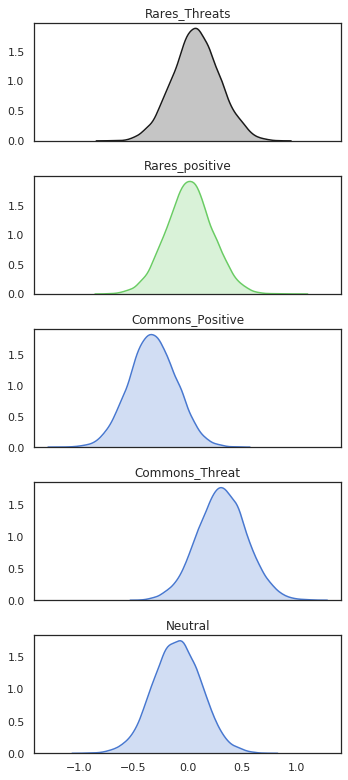

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns
from bayesian_bootstrap.bootstrap import mean, highest_density_interval
import pandas as pd

fit_df_2 = fit_fe_male.to_dataframe()

#Extract data
chain_idx = fit_df_2['draw']
neutral = fit_df_2['bConditions[{}]'.format(1)]
common_p = fit_df_2['bConditions[{}]'.format(2)]
common_t = fit_df_2['bConditions[{}]'.format(3)]
rare_p = fit_df_2['bConditions[{}]'.format(4)]
rare_t = fit_df_2['bConditions[{}]'.format(5)]

diff_v = rare_p-rare_t
rares=((rare_p+rare_t)/2.0)
commons=((common_p+common_t)/2.0)
diff_type=(common_t-rare_t)-(common_p-rare_p)
diff_rare=rare_p-rare_t
diff_ct_rares=common_t-rares
diff_common=common_t-common_p
diff_raret=common_t-rare_t
diff_n=neutral-rare_t
d_cp=rare_p-common_p
diff_n_ct=common_t-neutral
diff_n_cp=neutral-common_p


#Compute HDIs
l_ct, r_ct = highest_density_interval(common_t)
l_cp, r_cp = highest_density_interval(common_p)
l_r, r_r = highest_density_interval(diff_rare)   
l_rt,r_rt=highest_density_interval(diff_raret)
l_n,r_n=highest_density_interval(neutral)
le,re=highest_density_interval(diff_ct_rares)
l,r=highest_density_interval(d_cp)
nm,mm=highest_density_interval(diff_common)
lc,hc=highest_density_interval(diff_type)
lx,rx=highest_density_interval(diff_n_ct)
lxy,rxy=highest_density_interval(diff_n_cp)


rope=0.009


sns.set(style="white",
        palette="muted",
        color_codes=True)

f, axs = plt.subplots(5, 1, figsize=(5, 11),sharex=True)

ax0=sns.distplot(rare_t, hist=False,kde_kws={"shade": True},color="k", ax=axs[0])
ax0.set(title='Rares_Threats',xlabel='')

ax1=sns.distplot(rare_p, hist=False,kde_kws={"shade": True},color="g", ax=axs[1])
ax1.set(title='Rares_positive',xlabel='')

ax2=sns.distplot(common_p, hist=False, kde_kws={"shade": True},color="b", ax=axs[2])
ax2.set(title='Commons_Positive',xlabel='')

axct=sns.distplot(common_t, hist=False, kde_kws={"shade": True},color="b", ax=axs[3])
axct.set(title='Commons_Threat',xlabel='')

axct=sns.distplot(neutral, hist=False, kde_kws={"shade": True},color="b", ax=axs[4])
axct.set(title='Neutral',xlabel='')



plt.tight_layout()
plt.show()


-0.05082706923448388
-0.32668585501588643


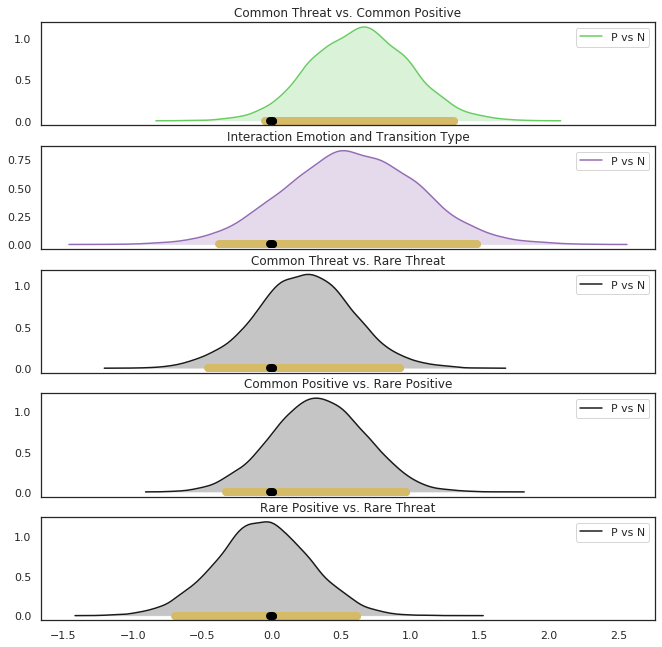

In [165]:
f, axs = plt.subplots(5, 1, figsize=(11, 11),sharex=True)

axv=sns.distplot(diff_type, hist=False, kde_kws={"shade": True},color="m", ax=axs[1],label='P vs N')
axv.set(title='Interaction Emotion and Transition Type',xlabel='')

axs[1].plot([lc, hc],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[1].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

axv=sns.distplot(diff_common, hist=False, kde_kws={"shade": True},color="g", ax=axs[0],label='P vs N')
axv.set(title='Common Threat vs. Common Positive',xlabel='')

axs[0].plot([nm, mm],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[0].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

axv=sns.distplot(diff_raret, hist=False, kde_kws={"shade": True},color="k", ax=axs[2],label='P vs N')
axv.set(title='Common Threat vs. Rare Threat',xlabel='')

axs[2].plot([l_rt, r_rt],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[2].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


axv=sns.distplot(d_cp, hist=False, kde_kws={"shade": True},color="k", ax=axs[3],label='P vs N')
axv.set(title='Common Positive vs. Rare Positive',xlabel='')

axs[3].plot([l, r],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[3].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

axv=sns.distplot(diff_rare, hist=False, kde_kws={"shade": True},color="k", ax=axs[4],label='P vs N')
axv.set(title='Rare Positive vs. Rare Threat',xlabel='')

axs[4].plot([l_r, r_r],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[4].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

print(nm)
print(l)

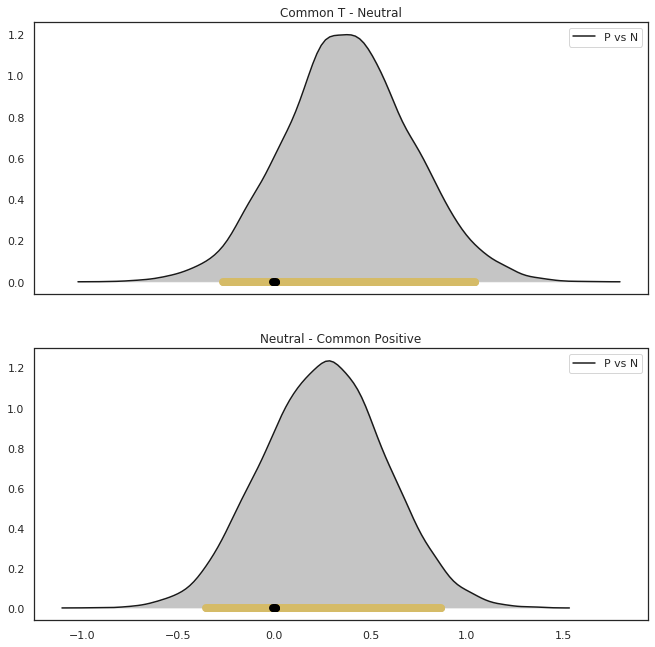

In [80]:
f, axs = plt.subplots(2, 1, figsize=(11, 11),sharex=True)

axv=sns.distplot(diff_n_ct, hist=False, kde_kws={"shade": True},color="k", ax=axs[0],label='P vs N')
axv.set(title='Common T - Neutral',xlabel='')

axs[0].plot([lx, rx],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[0].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

axv=sns.distplot(diff_n_cp, hist=False, kde_kws={"shade": True},color="k", ax=axs[1],label='P vs N')
axv.set(title='Neutral - Common Positive',xlabel='')

axs[1].plot([lxy, rxy],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[1].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

In [ ]:
# worst_subs=[46,64,66,137,142,153]
# best_subs=[1, 11, 13, 19, 20, 22, 26, 29, 35, 44, 50, 55, 57, 60, 69, 71, 79, 85, 90, 91, 97, 106, 107, 111,
#            113, 114, 116, 117, 118, 119, 123, 125, 127, 129, 133, 139, 144, 146, 147, 151, 154, 163, 166]
# bs=[]
# s_match=0
# ws=[]
# #best_subs=[]
# middle_subs=np.empty((0,5), int)
# pswq=np.delete(worry_data,(best_subs),axis=0)
# x=np.array((0,0,0,0,0))
# num_middle_subs=0
# for sub in range(176):
#     if sub not in bs:
#          if sub not in ws:
#             middle_subs=np.append(middle_subs,[choice_data[sub,:]],axis=0)
#             s_match+=1
#             x=x+choice_data[sub,:]
#             num_middle_subs+=1
# print(num_middle_subs)
# print(x/num_middle_subs)
# print(middle_subs.shape)
# print(len(best_subs))



#print(stats.pearsonr(pswq,middle_subs[:,4]))
# template1=np.array((1,0,1,1,1))
# template2=np.array((1,1,1,1,0))
# template3=np.array((1,0,1,1,0))
# template4=np.array((0,0,1,1,0))
# template5=np.array((0,1,1,1,0))
# template6=np.array((0,0,1,1,1))

#             if np.array_equal(choice_data[sub,:],template1):
#                 s_match+=1
#             elif np.array_equal(choice_data[sub,:],template2):
#                 s_match+=1
#             elif np.array_equal(choice_data[sub,:],template3):
#                 s_match+=1
# #             elif np.array_equal(choice_data[sub,:],template4):
# #                 s_match+=1
# #             elif np.array_equal(choice_data[sub,:],template5):
# #                 s_match+=1
# #             elif np.array_equal(choice_data[sub,:],template6):